In [1]:
import os
import cv2
import numpy as np
import random
from tensorflow.keras.utils import Sequence, to_categorical

class RadiographyDataGenerator(Sequence):
    def __init__(self, root_dir, batch_size=32, img_size=(224, 224), mode='train', split=0.2, shuffle=True, num_classes=4):
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.mode = mode
        self.split = split
        self.num_classes = num_classes
        self.class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

        self.data = self._load_data()
        self._split_data()
        self.on_epoch_end()

    def _load_data(self):
        data = []
        for label_idx, class_name in enumerate(self.class_names):
            image_dir = os.path.join(self.root_dir, class_name, "images")
            mask_dir = os.path.join(self.root_dir, class_name, "masks")

            for fname in os.listdir(image_dir):
                image_path = os.path.join(image_dir, fname)
                mask_path = os.path.join(mask_dir, fname)  # Assuming same name
                if os.path.exists(mask_path):  # Ensure mask exists
                    data.append((image_path, mask_path, label_idx))
        return data

    def _split_data(self):
        random.shuffle(self.data)
        split_idx = int(len(self.data) * (1 - self.split))
        if self.mode == 'train':
            self.data = self.data[:split_idx]
        else:
            self.data = self.data[split_idx:]

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_data = self.data[index * self.batch_size:(index + 1) * self.batch_size]
        images, masks, labels = [], [], []

        for img_path, mask_path, label in batch_data:
            # Load and resize image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.img_size)
            img = img.astype("float32") / 255.0
            img = np.expand_dims(img, axis=-1)  # shape: (224, 224, 1)

            # Load and resize mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.img_size)
            mask = mask.astype("float32") / 255.0

            images.append(img)
            masks.append(mask)
            labels.append(label)

        images = np.array(images)
        labels = to_categorical(labels, num_classes=self.num_classes)

        return images, labels  # You can also return masks if needed

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.data)


2025-08-07 05:20:13.978266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754544014.337120      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754544014.440493      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_gen = RadiographyDataGenerator(
    root_dir='/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset',
    mode='train',
    batch_size=32
)

val_gen = RadiographyDataGenerator(
    root_dir='/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset',
    mode='val',
    batch_size=32
)


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dropout, Reshape,
                                     LSTM, Dense, Bidirectional)

#CNN-LSTM MODEL
def build_cnn_lstm_model(input_shape=(224, 224, 1), num_classes=4):
    inputs = Input(shape=input_shape)

    # CNN Backbone
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)   # 112x112
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)   # 56x56
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)   # 28x28
    x = MaxPooling2D((2, 2))(x)   # 14x14

    # Flatten spatial to sequence for LSTM
    x = Reshape((14 * 14, 128))(x)

    # LSTM
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dropout(0.5)(x)

    # Output
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model = build_cnn_lstm_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


I0000 00:00:1754544125.852013      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754544125.852710      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 196, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 192,004 (750.02 KB)

 Trainable params: 192,004 (750.02 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
history = model.fit(train_gen, validation_data=val_gen, epochs=10)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1754544138.160643      93 cuda_dnn.cc:529] Loaded cuDNN version 90300


530/530 ━━━━━━━━━━━━━━━━━━━━ 382s 698ms/step - accuracy: 0.5277 - loss: 1.0686 - val_accuracy: 0.6974 - val_loss: 0.7680
Epoch 2/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 119s 222ms/step - accuracy: 0.6946 - loss: 0.7374 - val_accuracy: 0.7257 - val_loss: 0.6364
Epoch 3/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 102s 189ms/step - accuracy: 0.7494 - loss: 0.6197 - val_accuracy: 0.8046 - val_loss: 0.4967
Epoch 4/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 101s 188ms/step - accuracy: 0.7856 - loss: 0.5495 - val_accuracy: 0.7730 - val_loss: 0.5357
Epoch 5/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 101s 188ms/step - accuracy: 0.7911 - loss: 0.5247 - val_accuracy: 0.8240 - val_loss: 0.4415
Epoch 6/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 101s 189ms/step - accuracy: 0.8101 - loss: 0.4816 - val_accuracy: 0.8401 - val_loss: 0.4020
Epoch 7/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 106s 199ms/step - accuracy: 0.8245 - loss: 0.4382 - val_accuracy: 0.8301 - val_loss: 0.4042
Epoch 8/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 101s 189ms/step - accuracy: 0.8324 - loss: 0.42

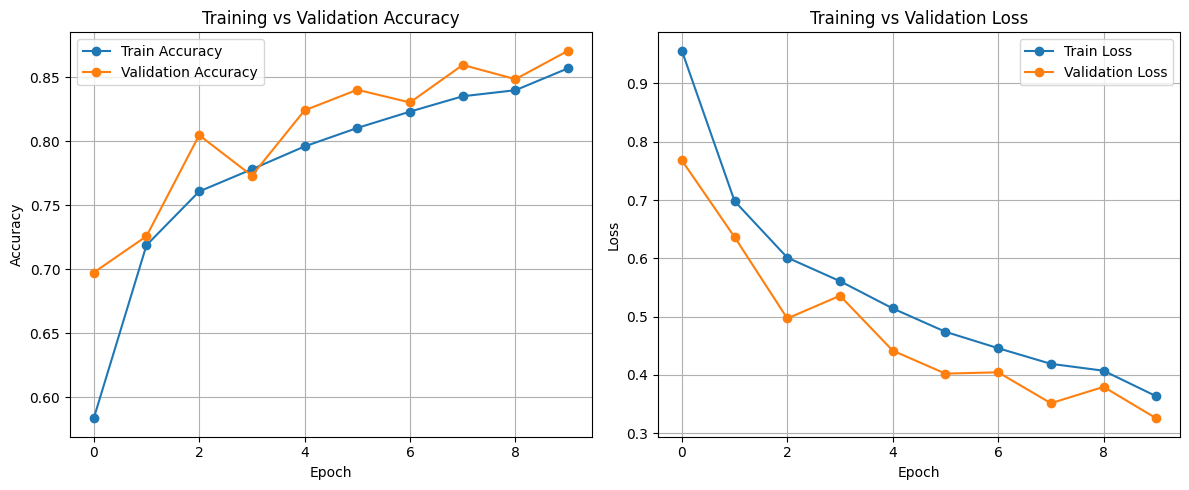

In [5]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Accuracy Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call this after model training
plot_training_history(history)


In [6]:
# Classification Report using fixed-length iteration
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_true, y_pred = [], []

# Loop safely over validation data
for i in range(len(val_gen)):
    X_batch, y_batch = val_gen[i]  # Indexed access avoids generator exhaustion issues
    preds = model.predict(X_batch, verbose=0)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Generate report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=val_gen.class_names))



Classification Report:

                 precision    recall  f1-score   support

          COVID       0.93      0.97      0.95       747
   Lung_Opacity       0.86      0.73      0.79      1231
         Normal       0.84      0.92      0.88      1996
Viral Pneumonia       0.98      0.92      0.95       259

       accuracy                           0.87      4233
      macro avg       0.90      0.88      0.89      4233
   weighted avg       0.87      0.87      0.87      4233



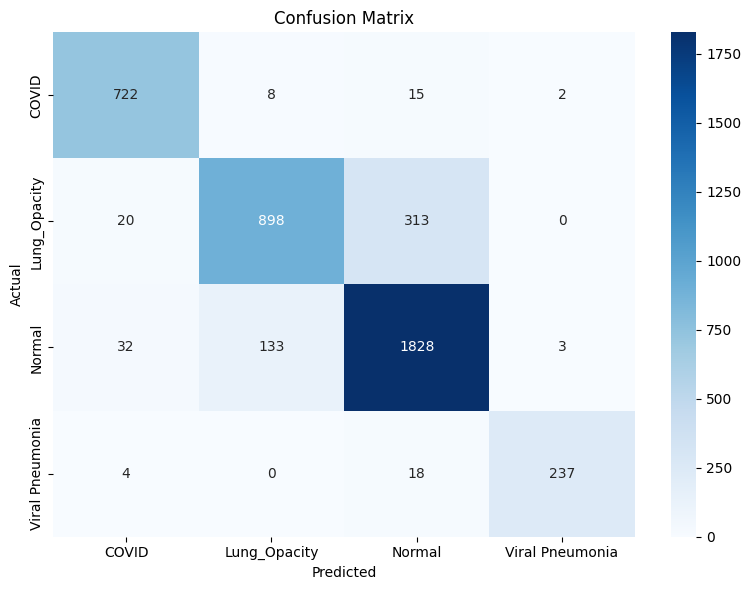

In [7]:
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [8]:
import os
import cv2
import numpy as np
import random
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from sklearn.metrics import classification_report
import tensorflow as tf

# -----------------------------
# Data Generator Class
# -----------------------------
class RadiographyDataGenerator(Sequence):
    def __init__(self, root_dir, batch_size=32, img_size=(224, 224), mode='train', split=0.2, shuffle=True, num_classes=4):
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.mode = mode
        self.split = split
        self.num_classes = num_classes
        self.class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

        print("\n[INFO] Loading dataset paths and splitting...")
        self.data = self._load_data()
        self._split_data()
        self.on_epoch_end()
        print(f"[INFO] {self.mode.upper()} set: {len(self.data)} samples\n")

    def _load_data(self):
        data = []
        for label_idx, class_name in enumerate(self.class_names):
            image_dir = os.path.join(self.root_dir, class_name, "images")
            mask_dir = os.path.join(self.root_dir, class_name, "masks")
            for fname in os.listdir(image_dir):
                image_path = os.path.join(image_dir, fname)
                mask_path = os.path.join(mask_dir, fname)
                if os.path.exists(mask_path):
                    data.append((image_path, mask_path, label_idx))
        return data

    def _split_data(self):
        random.shuffle(self.data)
        split_idx = int(len(self.data) * (1 - self.split))
        if self.mode == 'train':
            self.data = self.data[:split_idx]
        else:
            self.data = self.data[split_idx:]

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_data = self.data[index * self.batch_size:(index + 1) * self.batch_size]
        images, masks, labels = [], [], []

        for img_path, mask_path, label in batch_data:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Resize
            img = cv2.resize(img, self.img_size)
            mask = cv2.resize(mask, self.img_size)

            # Normalize and expand dims
            img = np.expand_dims(img.astype("float32") / 255.0, axis=-1)
            mask = np.expand_dims(mask.astype("float32") / 255.0, axis=-1)

            # Concatenate as two channels
            combined = np.concatenate([img, mask], axis=-1)

            images.append(combined)
            labels.append(label)

        images = np.array(images)
        labels = to_categorical(labels, num_classes=self.num_classes)

        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.data)

# -----------------------------
# CNN Model Definition
# -----------------------------
def build_vanilla_cnn(input_shape=(224, 224, 2), num_classes=4):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# -----------------------------
# Training and Evaluation
# -----------------------------
if __name__ == "__main__":
    root_dir = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'

    train_gen = RadiographyDataGenerator(root_dir=root_dir, mode='train', batch_size=32)
    val_gen = RadiographyDataGenerator(root_dir=root_dir, mode='val', batch_size=32)

    model = build_vanilla_cnn()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    print("\n[INFO] Starting training...")
    history = model.fit(train_gen, validation_data=val_gen, epochs=10)

    


[INFO] Loading dataset paths and splitting...
[INFO] TRAIN set: 16932 samples


[INFO] Loading dataset paths and splitting...
[INFO] VAL set: 4233 samples



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 2)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 32)        │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,938,660 (49.36 MB)

 Trainable params: 12,938,660 (49.36 MB)

 Non-trainable params: 0 (0.00 B)


[INFO] Starting training...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1754545494.784469      94 service.cc:148] XLA service 0xfd9a3e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754545494.790198      94 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754545494.790224      94 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/530 ━━━━━━━━━━━━━━━━━━━━ 1:20:33 9s/step - accuracy: 0.1875 - loss: 1.3851

I0000 00:00:1754545499.674781      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


530/530 ━━━━━━━━━━━━━━━━━━━━ 153s 273ms/step - accuracy: 0.6538 - loss: 0.8690 - val_accuracy: 0.8450 - val_loss: 0.3966
Epoch 2/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 104s 193ms/step - accuracy: 0.8509 - loss: 0.3930 - val_accuracy: 0.8923 - val_loss: 0.3011
Epoch 3/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 99s 184ms/step - accuracy: 0.8921 - loss: 0.3005 - val_accuracy: 0.9086 - val_loss: 0.2580
Epoch 4/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 99s 185ms/step - accuracy: 0.9100 - loss: 0.2464 - val_accuracy: 0.9374 - val_loss: 0.1934
Epoch 5/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 97s 182ms/step - accuracy: 0.9263 - loss: 0.1982 - val_accuracy: 0.9343 - val_loss: 0.1869
Epoch 6/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 104s 195ms/step - accuracy: 0.9422 - loss: 0.1580 - val_accuracy: 0.9546 - val_loss: 0.1351
Epoch 7/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 100s 187ms/step - accuracy: 0.9512 - loss: 0.1323 - val_accuracy: 0.9523 - val_loss: 0.1355
Epoch 8/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 99s 185ms/step - accuracy: 0.9553 - loss: 0.1174 -

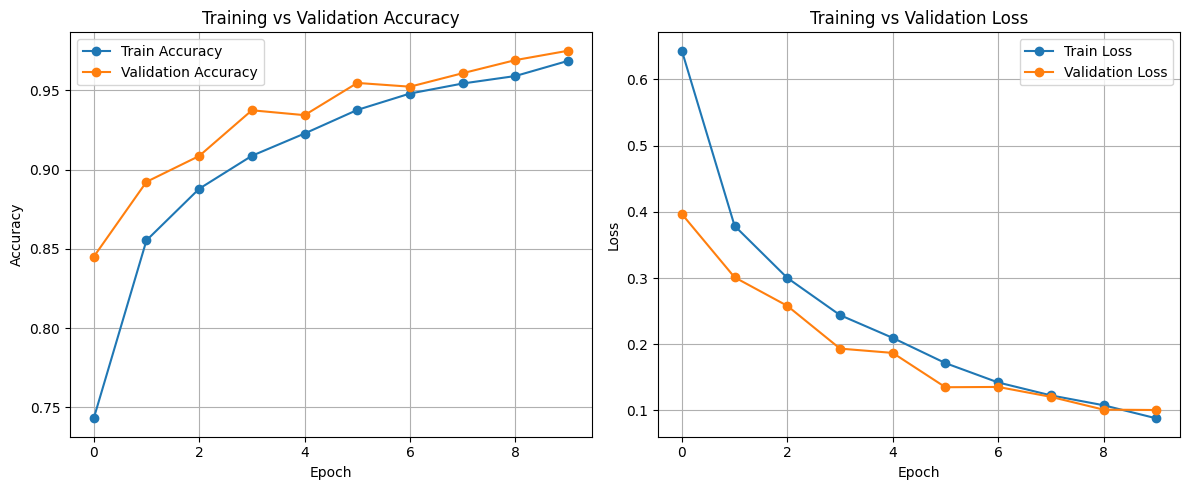

In [9]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Accuracy Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call this after model training
plot_training_history(history)


In [10]:
# Classification Report using fixed-length iteration
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_true, y_pred = [], []

# Loop safely over validation data
for i in range(len(val_gen)):
    X_batch, y_batch = val_gen[i]  # Indexed access avoids generator exhaustion issues
    preds = model.predict(X_batch, verbose=0)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Generate report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=val_gen.class_names))



Classification Report:

                 precision    recall  f1-score   support

          COVID       0.98      0.99      0.99       725
   Lung_Opacity       0.99      0.94      0.96      1216
         Normal       0.96      0.99      0.98      2015
Viral Pneumonia       1.00      0.99      0.99       277

       accuracy                           0.97      4233
      macro avg       0.98      0.98      0.98      4233
   weighted avg       0.98      0.97      0.97      4233



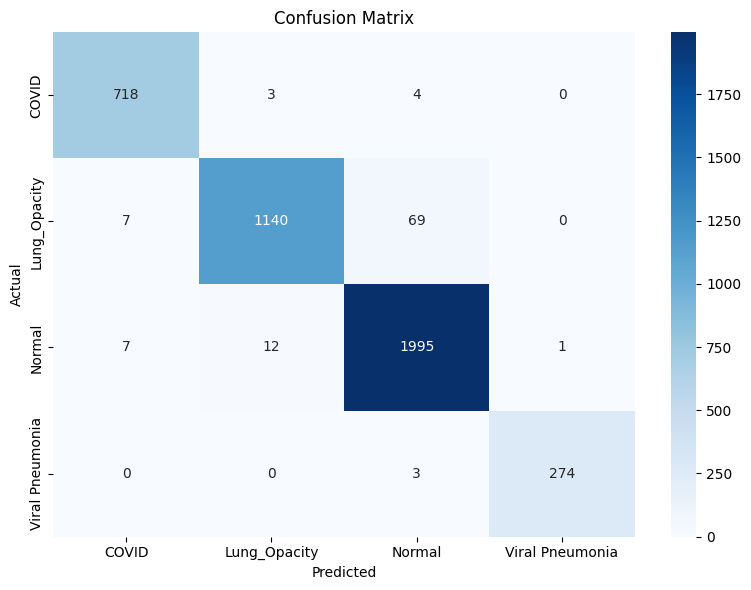

In [11]:
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [12]:
import cv2
import numpy as np

def classify_image(model, image_path, mask_path, class_names, img_size=(224, 224)):
    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_size)
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=-1)  # (224, 224, 1)

    # Load and preprocess mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, img_size)
    mask = mask.astype("float32") / 255.0
    mask = np.expand_dims(mask, axis=-1)  # (224, 224, 1)

    # Combine image and mask (if model was trained this way)
    combined = np.concatenate([img, mask], axis=-1)  # shape: (224, 224, 2)
    combined = np.expand_dims(combined, axis=0)      # shape: (1, 224, 224, 2)

    # Predict
    preds = model.predict(combined, verbose=0)
    class_idx = np.argmax(preds[0])
    class_name = class_names[class_idx]
    confidence = preds[0][class_idx]

    print(f"Predicted Class: {class_name} ({confidence * 100:.2f}% confidence)")
    return class_name, confidence


In [13]:
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

image_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1.png"
mask_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/masks/Viral Pneumonia-1.png"

classify_image(model, image_path, mask_path, class_names)


Predicted Class: Viral Pneumonia (100.00% confidence)


('Viral Pneumonia', 1.0)

In [14]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf

# -----------------------------
# Data Generator
# -----------------------------
class RadiographyDataGenerator(Sequence):
    def __init__(self, root_dir, batch_size=32, img_size=(224, 224), mode='train', split=0.2, shuffle=True, num_classes=4):
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.mode = mode
        self.split = split
        self.num_classes = num_classes
        self.class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

        self.data = self._load_data()
        self._split_data()
        self.on_epoch_end()

    def _load_data(self):
        data = []
        for label_idx, class_name in enumerate(self.class_names):
            image_dir = os.path.join(self.root_dir, class_name, "images")
            mask_dir = os.path.join(self.root_dir, class_name, "masks")
            for fname in os.listdir(image_dir):
                image_path = os.path.join(image_dir, fname)
                mask_path = os.path.join(mask_dir, fname)
                if os.path.exists(mask_path):
                    data.append((image_path, mask_path, label_idx))
        return data

    def _split_data(self):
        random.shuffle(self.data)
        split_idx = int(len(self.data) * (1 - self.split))
        if self.mode == 'train':
            self.data = self.data[:split_idx]
        else:
            self.data = self.data[split_idx:]

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_data = self.data[index * self.batch_size:(index + 1) * self.batch_size]
        images, labels = [], []

        for img_path, mask_path, label in batch_data:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.img_size)
            mask = cv2.resize(mask, self.img_size)
            img = np.expand_dims(img.astype("float32") / 255.0, axis=-1)
            mask = np.expand_dims(mask.astype("float32") / 255.0, axis=-1)
            combined = np.concatenate([img, mask], axis=-1)
            images.append(combined)
            labels.append(label)

        return np.array(images), to_categorical(labels, num_classes=self.num_classes)

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.data)

# -----------------------------
# ResNet Model
# -----------------------------
def build_resnet_model(input_shape=(224, 224, 2), num_classes=4):
    inputs = Input(shape=input_shape)

    # Step 1: Convert 2-channel to 3-channel
    x = Conv2D(3, (1, 1), padding='same')(inputs)

    # Step 2: Apply preprocessing
    x = preprocess_input(x)

    # Step 3: Load pretrained ResNet base
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = False

    # Step 4: Pass input through base model
    x = base_model(x, training=False)  # <-- important fix

    # Step 5: Add custom classification layers
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=inputs, outputs=outputs)
# -----------------------------
# Train + Evaluate
# -----------------------------
root_dir = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'
train_gen = RadiographyDataGenerator(root_dir=root_dir, mode='train')
val_gen = RadiographyDataGenerator(root_dir=root_dir, mode='val')

model = build_resnet_model()
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(train_gen, validation_data=val_gen, epochs=10)



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 2)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 224, 224, 3)    │              9 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │        262,272 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 4)              │            516 │ dense_3[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,850,509 (90.98 MB)

 Trainable params: 262,797 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


530/530 ━━━━━━━━━━━━━━━━━━━━ 145s 234ms/step - accuracy: 0.4249 - loss: 1.3580 - val_accuracy: 0.4751 - val_loss: 1.1917
Epoch 2/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 108s 202ms/step - accuracy: 0.4780 - loss: 1.1889 - val_accuracy: 0.4751 - val_loss: 1.1605
Epoch 3/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 113s 210ms/step - accuracy: 0.4951 - loss: 1.1687 - val_accuracy: 0.4751 - val_loss: 1.1438
Epoch 4/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 114s 214ms/step - accuracy: 0.5105 - loss: 1.1269 - val_accuracy: 0.5327 - val_loss: 1.0851
Epoch 5/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 113s 211ms/step - accuracy: 0.5357 - loss: 1.0918 - val_accuracy: 0.5268 - val_loss: 1.0432
Epoch 6/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 113s 211ms/step - accuracy: 0.5600 - loss: 1.0442 - val_accuracy: 0.5797 - val_loss: 0.9917
Epoch 7/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 113s 211ms/step - accuracy: 0.5753 - loss: 1.0244 - val_accuracy: 0.6241 - val_loss: 0.9476
Epoch 8/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 113s 211ms/step - accuracy: 0.5999 - loss: 0.98

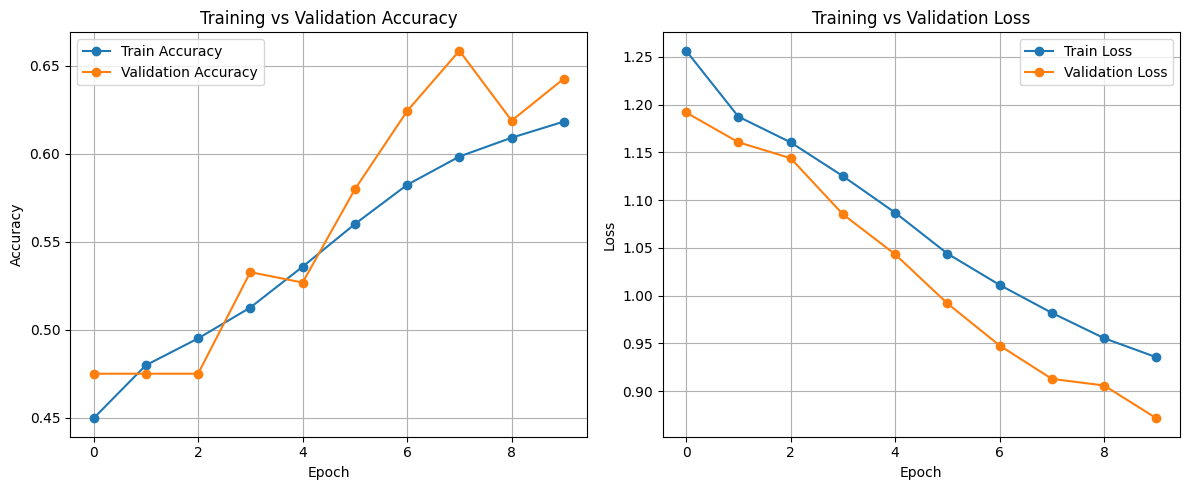

In [15]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Accuracy Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call this after model training
plot_training_history(history)


In [16]:
# Classification Report using fixed-length iteration
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_true, y_pred = [], []

# Loop safely over validation data
for i in range(len(val_gen)):
    X_batch, y_batch = val_gen[i]  # Indexed access avoids generator exhaustion issues
    preds = model.predict(X_batch, verbose=0)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Generate report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=val_gen.class_names))



Classification Report:

                 precision    recall  f1-score   support

          COVID       0.65      0.02      0.05       712
   Lung_Opacity       0.68      0.62      0.65      1218
         Normal       0.62      0.93      0.75      2011
Viral Pneumonia       0.93      0.24      0.38       292

       accuracy                           0.64      4233
      macro avg       0.72      0.45      0.45      4233
   weighted avg       0.67      0.64      0.58      4233



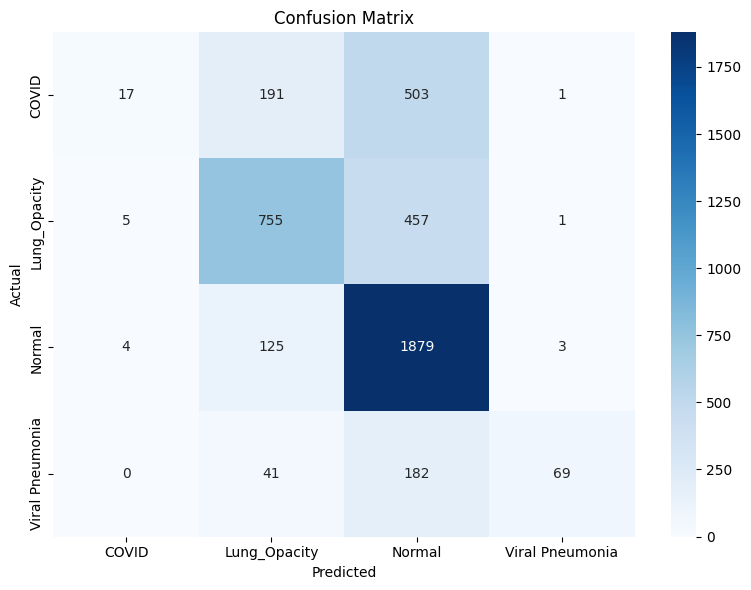

In [17]:
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
